In [122]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

tss_df = pd.read_csv("data/combined_data.csv")
items_descr = pd.read_csv("data/description_items.csv")

tss_df.drop(columns="Unnamed: 0", inplace=True)
tss_df.head(3)

,response_id,story_id,prompt_label,preset_label,sample,tts_coh_1,tts_coh_2,tts_coh_3,tts_coh_4,tts_coh_5,...,start,end,duration_in_sec,recorded,tts_order,qual_check_1,qual_check_1_order,qual_check_2,pass_qual_1,pass_qual_2
0,R_3LZPTbqxmeWvp7w,GEN_HF_6,High Fantasy,Genesis,Community,2.0,4.0,4.0,4.0,4.0,...,2022-02-17 07:41:22,2022-02-17 07:58:46,1044,2022-02-17 07:58:47,1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|1...,NaN,NaN,NaN,NaN,NaN
1,R_pSlyunfdAKMG8EN,GEN_HF_6,High Fantasy,Genesis,SurveySwap,2.0,3.0,4.0,4.0,4.0,...,2022-02-21 01:10:19,2022-02-21 01:17:01,402,2022-02-21 07:20:12,Nothing seemed to be happening in the story.|T...,...the description of a small village.,...someone working in a tavern.|...a noise com...,2.0,True,True
2,R_3CCMkj9T7UgOtgP,ALL_HR_3,Historical Romance,All-Nighter,Community,2.0,4.0,2.0,1.0,2.0,...,2022-02-17 07:52:11,2022-02-17 08:01:19,548,2022-02-17 08:01:20,1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|1...,NaN,NaN,NaN,NaN,NaN


In [123]:
items_descr.head(3)

,Unnamed: 0,0
0,Qual_Check_1,"The story I just read, began with..."
1,Qual_Check_1_DO,"The story I just read, began with... - Display..."
2,tts_coh_1,I had a hard time making sense of what was goi...


In [124]:
tss_df.columns

Index(['response_id', 'story_id', 'prompt_label', 'preset_label', 'sample',
       'tts_coh_1', 'tts_coh_2', 'tts_coh_3', 'tts_coh_4', 'tts_coh_5',
       'tts_coh_6', 'tts_coh_7', 'tts_coh_8', 'tts_coh_9', 'tts_coh_10',
       'tts_coh_11', 'tts_coh_12', 'tts_conch_1', 'tts_conch_2', 'tts_conch_3',
       'tts_conch_4', 'tts_conch_5', 'tts_conch_6', 'tts_conch_7',
       'tts_conch_8', 'tss_cre_1', 'tss_cre_2', 'tss_cre_3', 'tss_cre_4',
       'tss_cre_5', 'tss_cre_6', 'tss_cre_7', 'tss_cre_8', 'tss_cre_9',
       'tss_cre_10', 'tss_cre_11', 'tss_cre_12', 'tts_qua_1', 'tts_qua_2',
       'tts_qua_3', 'tts_qua_4', 'tts_qua_5', 'tts_qua_6', 'tts_qua_7',
       'tts_qua_8', 'tts_rep_1', 'tts_rep_2', 'tts_rep_3', 'tts_rep_4',
       'tts_rep_5', 'tts_rep_6', 'tts_rep_7', 'tts_rep_8', 'tts_rep_9',
       'tts_rep_10', 'tts_rep_11', 'tts_rep_12', 'tts_sty_1', 'tts_sty_2',
       'tts_sty_3', 'tts_sty_4', 'tts_sty_5', 'tts_sty_6', 'tts_sty_7',
       'tts_sty_8', 'tts_sty_9', 'tts_sty_10', '

In [125]:
item_labels_li = [
    'tts_coh_1', 'tts_coh_2', 'tts_coh_3', 'tts_coh_4',
       'tts_coh_5', 'tts_coh_6', 'tts_coh_7', 'tts_coh_8', 'tts_coh_9',
       'tts_coh_10', 'tts_coh_11', 'tts_coh_12', 'tts_conch_1', 'tts_conch_2',
       'tts_conch_3', 'tts_conch_4', 'tts_conch_5', 'tts_conch_6',
       'tts_conch_7', 'tts_conch_8', 'tss_cre_1', 'tss_cre_2', 'tss_cre_3',
       'tss_cre_4', 'tss_cre_5', 'tss_cre_6', 'tss_cre_7', 'tss_cre_8',
       'tss_cre_9', 'tss_cre_10', 'tss_cre_11', 'tss_cre_12', 'tts_qua_1',
       'tts_qua_2', 'tts_qua_3', 'tts_qua_4', 'tts_qua_5', 'tts_qua_6',
       'tts_qua_7', 'tts_qua_8', 'tts_rep_1', 'tts_rep_2', 'tts_rep_3',
       'tts_rep_4', 'tts_rep_5', 'tts_rep_6', 'tts_rep_7', 'tts_rep_8',
       'tts_rep_9', 'tts_rep_10', 'tts_rep_11', 'tts_rep_12', 'tts_sty_1',
       'tts_sty_2', 'tts_sty_3', 'tts_sty_4', 'tts_sty_5', 'tts_sty_6',
       'tts_sty_7', 'tts_sty_8', 'tts_sty_9', 'tts_sty_10', 'tts_sty_11',
       'tts_sty_12', 'tts_pac_1', 'tts_pac_2', 'tts_pac_3', 'tts_pac_4',
       'tts_pac_5', 'tts_pac_6', 'tts_pac_7', 'tts_pac_8', 'tts_pac_9'
]


# check if items are appropriate for EFA
# correlations mostly |.3|-|.8|
items_corr = tss_df[item_labels_li].corr()

extreme_corrs_count_dict = {}

# print out extreme corrs
total_report = ""
for index, row in items_corr.iterrows():
    variable1 = index
    corrs = row
    i = 0
    count = 0
    for variable2, corr in corrs.iteritems():
        if (abs(corr) < 0.3) or (abs(corr) > 0.8):
            count += 1
        i += 1
    extreme_corrs_count_dict[variable1] = count

extreme_corrs_count = pd.Series(extreme_corrs_count_dict)
print("Descriptives for extreme correlation count:")
print(extreme_corrs_count.describe())

# uhmm that is more extreme correlations as I would like
# but maybe subscales are fairly orthogonal?

Descriptives for extreme correlation count:
count    73.000000
mean     51.739726
std       9.824894
min      31.000000
25%      44.000000
50%      54.000000
75%      58.000000
max      73.000000
dtype: float64


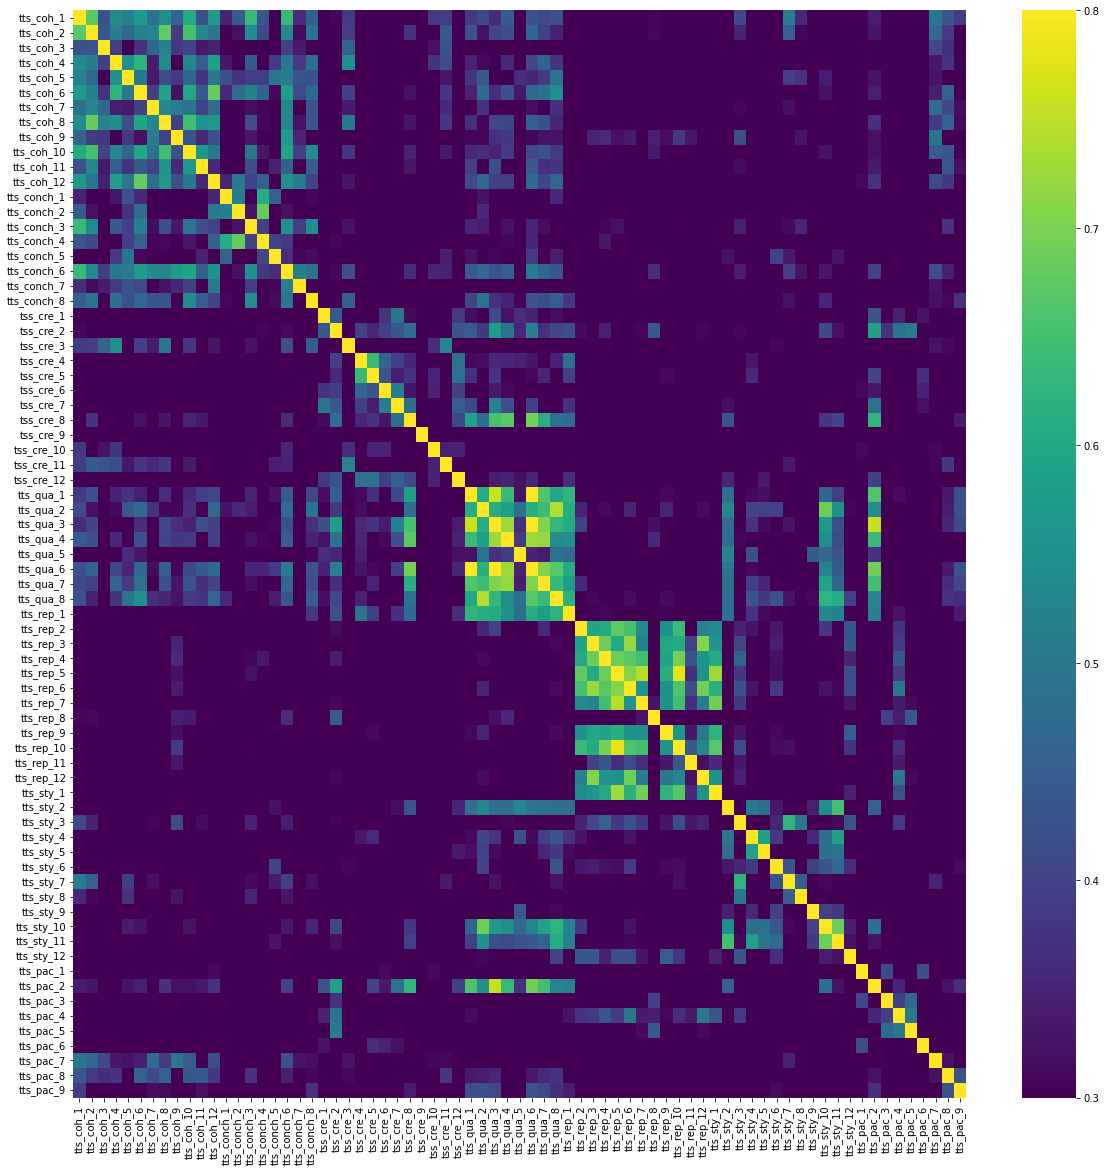

In [126]:
# Let us look at a heatmap (absolute values of correlations)
fig, ax = plt.subplots(figsize=(20, 20))

ax = sns.heatmap(abs(items_corr), 
            xticklabels=items_corr.columns.values,
            yticklabels=items_corr.columns.values,
                ax=ax, cmap = "viridis", vmin = 0.3, vmax=0.8)

# most scales are just surprising orthogonal (which is actually nice)

# Good:
# coherence looks good
# quality

# Potentially troublesome: Take a closer look later:
# consistent characterization
# creativity
# repition 8
# style
# pacing (but partly correlates with quality)